# EDA of climate data
Belonging Repository: https://github.com/mic1899/earth_surface_temperature/tree/dev_main

Belonging Data Source: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data


In [47]:
# Loading the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import plotly.express as px
from math import sqrt

from sklearn.metrics import mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os # accessing directory structure

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
from scipy import signal
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

%matplotlib inline

# Defining some general plot settings
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['agg.path.chunksize'] = 200

In [59]:
# Class for colored terminal outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
   ITALIC = '\033[3m'

print(color.BLUE + "Hier kommt ein Text" + color.END)

Hier kommt ein Text


In [4]:
# Defining the file names and path
PATH = "/home/rapunzel/home/projects/earth_surface_temperature/data/"
shorts = ["city", "country", "majorcity", "global", "state"]
datasets = dict(zip(shorts,os.listdir(PATH)))
# loading the different data sets
i = shorts[0]
df = pd.read_csv(PATH+datasets[i], delimiter=',')
df.name = i



In [5]:
df.query("City == 'Zurich'").tail()
#d.to_datetime(df['dt']).toordinal()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
8592839,2013-05-01,9.400,0.396,Zurich,Switzerland,47.42N,8.29E
8592840,2013-06-01,14.444,0.388,Zurich,Switzerland,47.42N,8.29E
8592841,2013-07-01,18.658,0.231,Zurich,Switzerland,47.42N,8.29E
8592842,2013-08-01,16.657,0.490,Zurich,Switzerland,47.42N,8.29E
8592843,2013-09-01,NaN,NaN,Zurich,Switzerland,47.42N,8.29E


In [6]:
def time_conv(df):
    # Convert timestamp to datetime object
    # Extract additional features from timestamp column
    df = df.assign(
        date = lambda x: pd.to_datetime(x['dt']),
        year = lambda x: x['date'].dt.year,
        month = lambda x: x['date'].dt.month,
        day = lambda x: x['date'].dt.day,
        dayofyear = lambda x: x['date'].dt.dayofyear
    )
    # Set Index to datetime object date
    df = df.set_index("date")
    # Impute the missing values in AverageTemperature using interpolate method
    df = df.assign(AverageTemperature=df.AverageTemperature.squeeze().interpolate(method='time'))
    return df
df = time_conv(df)

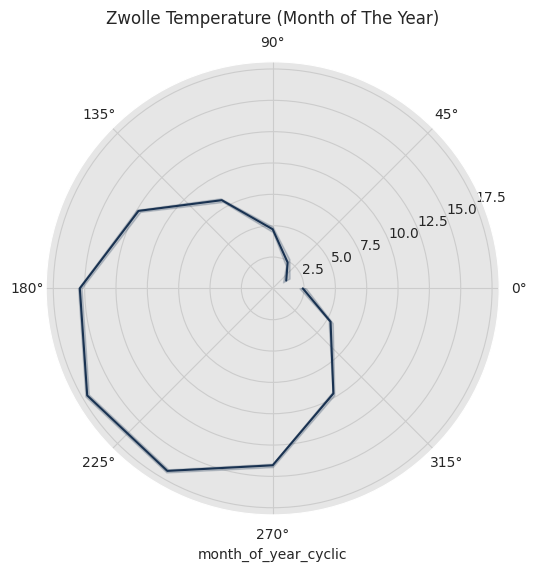

In [174]:
def plot_seasons(df, city):    
    # Polar plot for seasonality 
    ax = plt.subplot(111, projection='polar')
    daily_data_df = df[df.City==city]

    # Convert and plot data
    daily_data_df \
        .assign(month_of_year_cyclic = lambda x: x['month'].transform(lambda x: 2*np.pi*x/12)) \
        .pipe((sns.lineplot, 'data'), 
            x='month_of_year_cyclic', 
            y='AverageTemperature', 
            ax=ax
        )

    ax.set_ylabel('')
    ax.set_title(city + ' Temperature (Month of The Year)', va='bottom');

plot_seasons(df, "Zwolle")

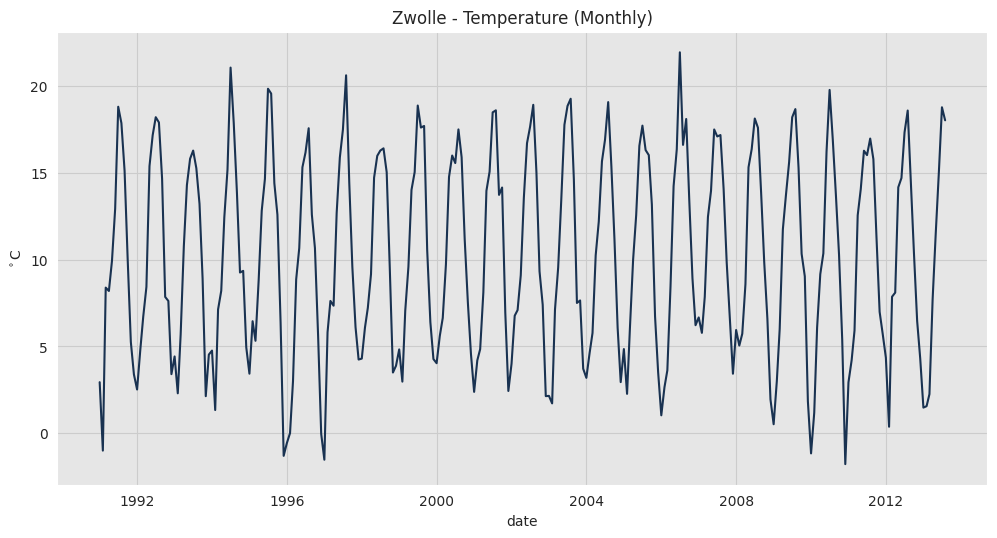

In [173]:
def plot_temp(df, city):
    daily_data_df = df[df.City==city]
    # Plot temperature on daily basis 
    fig, ax = plt.subplots()
    sns.lineplot(x='date', y='AverageTemperature', data=daily_data_df.reset_index(), ax=ax)
    ax.set(title=city + ' - Temperature (Monthly)', ylabel=r'$^\circ$C');

plot_temp(df.query("year>1990"), "Zwolle")

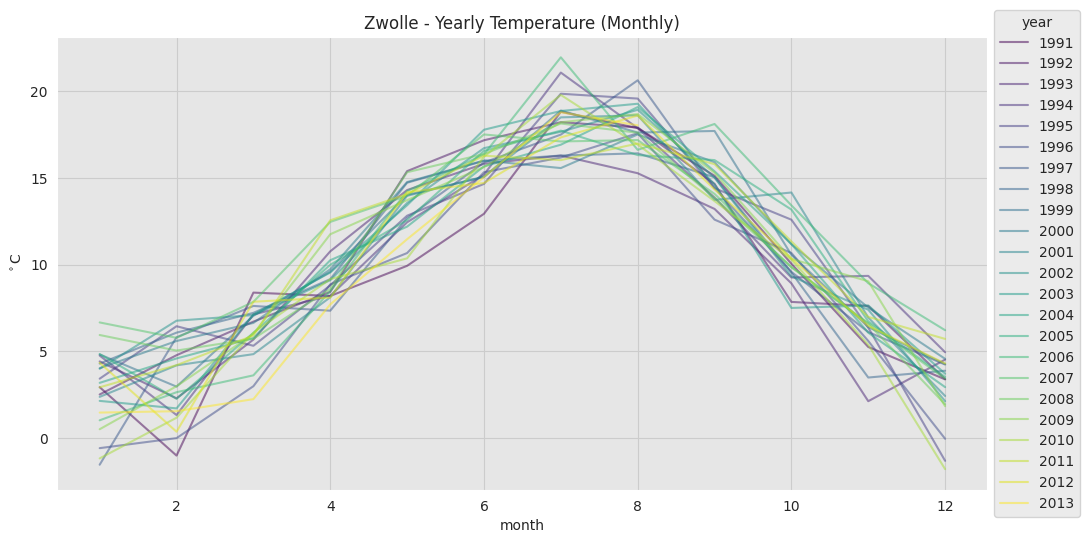

In [172]:
def plot_yearly_season(df, city):
    daily_data_df = df[df.City==city].dropna()
    # Plot yearly seasonality
    fig, ax = plt.subplots() 

    pd.pivot_table(data=daily_data_df[['year', 'month', 'AverageTemperature']], index='month', columns='year') \
        ['AverageTemperature'] \
        .plot(cmap='viridis', alpha=0.5, ax=ax)

    ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(title=city + ' - Yearly Temperature (Monthly)', ylabel=r'$^\circ$C');

plot_yearly_season(df.query("year>1990"), "Zwolle")

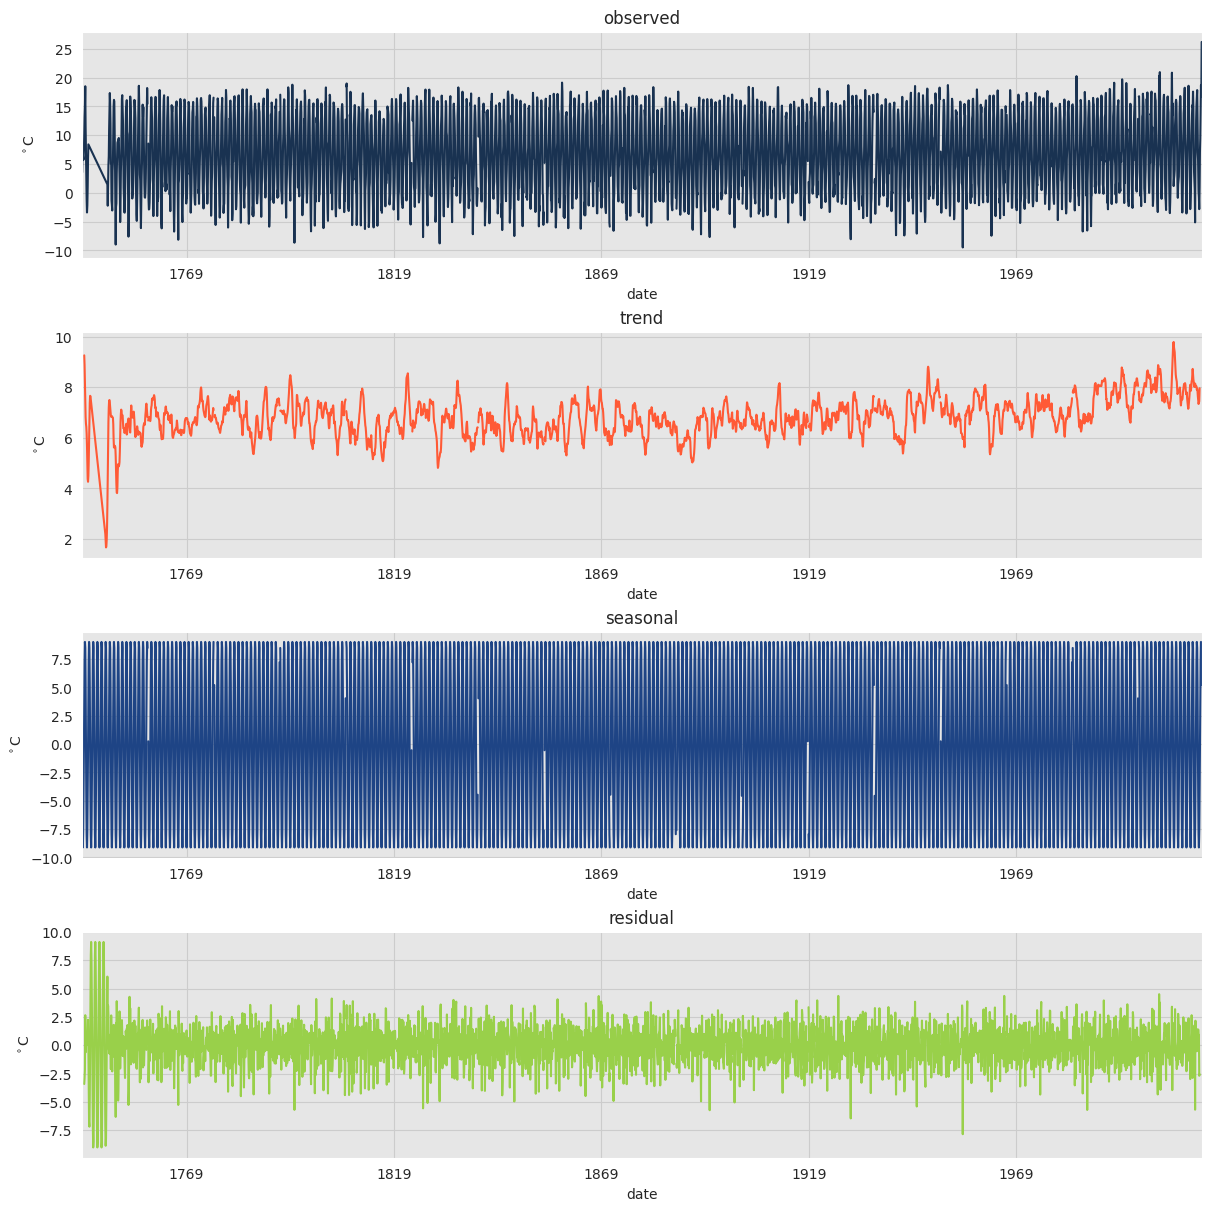

In [30]:
def trend_season_residual(df, column, city):
    df = df[df.City==city]
    df = df.dropna(subset=[column])
    # We use the parameter `period` = 12 to extract the yearly seasonality. 
    seas_decomp_yearly = seasonal_decompose(
        x=df[column], 
        model='additive', 
        period=12
    )

    # Plot data
    fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

    seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax[0])
    ax[0].set(title='observed', ylabel=r'$^\circ$C')
    seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax[1])
    ax[1].set(title='trend', ylabel=r'$^\circ$C')
    seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax[2])
    ax[2].set(title='seasonal', ylabel=r'$^\circ$C')
    seas_decomp_yearly.resid.plot(c=sns_c[3], ax=ax[3])
    ax[3].set(title='residual', ylabel=r'$^\circ$C');
    return seas_decomp_yearly

seas_decomb_yearly = trend_season_residual(df, 'AverageTemperature', "Zurich")

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -7.026256
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject H0 - Time Series is Stationary
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 1.086240
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Failed to Reject H0 - Time Series is Stationary
----------------------------------------


/home/rapunzel/home/projects/earth_surface_temperature/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


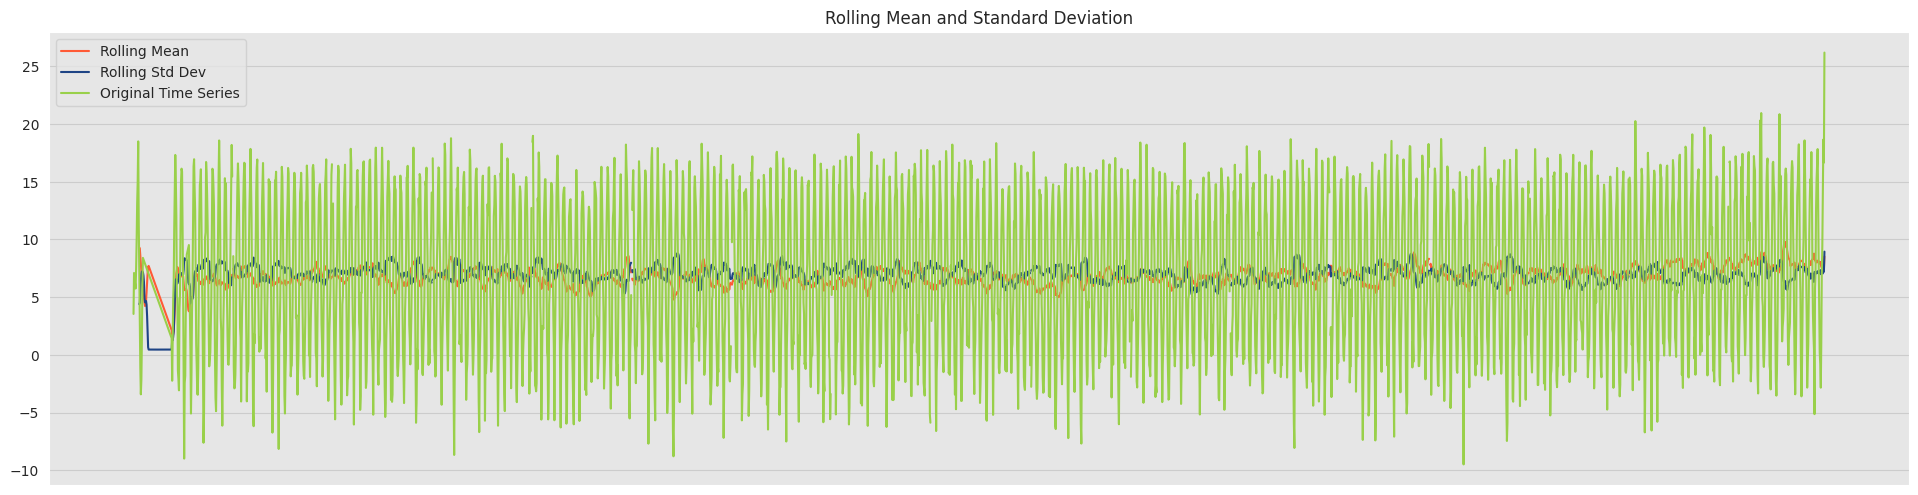

In [18]:
# Test for stationarity 

def stationarity_test(df, column, city, significance_level):
    df = df[df.City==city]
    df = df[column].squeeze()
    #df = df.dropna()
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = df.rolling(12).mean()
    rolling_std_dev = df.rolling(12).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(df, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print('ADF Test:')
    adf_test = adfuller(df,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print("Critical Values:")
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))
    if adf_test[1]<significance_level:# abs(adf_test[0]) > abs(adf_test[4][significance_level+"%"]) 
        print("Reject H0 - Time Series is Stationary")
    else:
        print("Failed to Reject H0 - Time Series is Non-Stationary")
    print('----'*10)
    
    # KPSS test
    print('KPSS Test:')
    kpss_test = kpss(df, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print("Critical Values:")
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    if kpss_test[1]<significance_level:# or abs(kpss_test[0]) < abs(kpss_test[3]["5%"]):
        print("Reject H0 - Time Series is Non-Stationary")
    else:
        print("Failed to Reject H0 - Time Series is Stationary")
    print('----'*10)
    
stationarity_test(df, 'AverageTemperature', 'Zurich', significance_level=0.01)

In [15]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,day,dayofyear
date,,,,,,,,,,,
1743-11-01,1743-11-01,6.068000,1.737,Århus,Denmark,57.05N,10.33E,1743,11,1,305
1743-12-01,1743-12-01,7.094947,NaN,Århus,Denmark,57.05N,10.33E,1743,12,1,335
1744-01-01,1744-01-01,6.634026,NaN,Århus,Denmark,57.05N,10.33E,1744,1,1,1
1744-02-01,1744-02-01,6.173105,NaN,Århus,Denmark,57.05N,10.33E,1744,2,1,32
1744-03-01,1744-03-01,5.741921,NaN,Århus,Denmark,57.05N,10.33E,1744,3,1,61


/home/rapunzel/home/projects/earth_surface_temperature/.venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


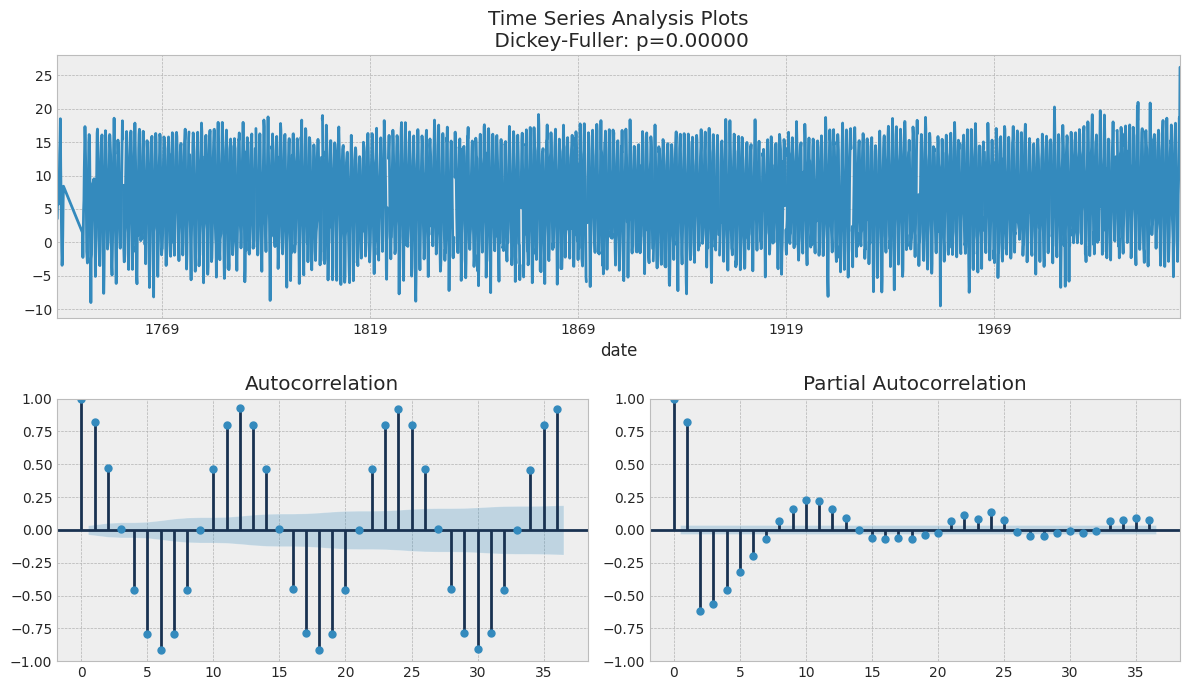

In [23]:
# From Kaggle.com
# https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook

def tsplot(df, city, lags=None, figsize=(12, 7), style='bmh'):

    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        df - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    df = df[df.City==city].AverageTemperature.squeeze()
    if not isinstance(df, pd.Series):
        df = pd.Series(df)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        df.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(df)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(df, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(df, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(df, 'Zurich')


In [24]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,day,dayofyear
date,,,,,,,,,,,
1743-11-01,1743-11-01,6.068000,1.737,Århus,Denmark,57.05N,10.33E,1743,11,1,305
1743-12-01,1743-12-01,7.094947,NaN,Århus,Denmark,57.05N,10.33E,1743,12,1,335
1744-01-01,1744-01-01,6.634026,NaN,Århus,Denmark,57.05N,10.33E,1744,1,1,1
1744-02-01,1744-02-01,6.173105,NaN,Århus,Denmark,57.05N,10.33E,1744,2,1,32
1744-03-01,1744-03-01,5.741921,NaN,Århus,Denmark,57.05N,10.33E,1744,3,1,61


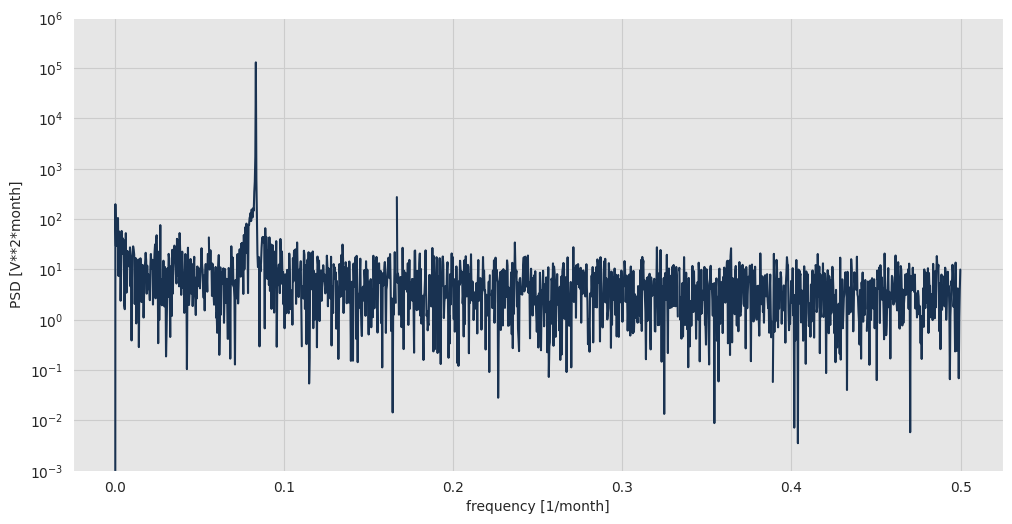

In [60]:
def plot_periodes(df, column, city):
    df = df[df.City==city]
    df = df[column].squeeze()

    f, Pxx_den = signal.periodogram(df)

    plt.semilogy(f, Pxx_den)
    plt.ylim([1e-3, 1e6])
    plt.xlabel('frequency [1/month]')
    plt.ylabel('PSD [V**2*month]')
    plt.show()

plot_periodes(df, 'AverageTemperature', 'Zurich')

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -18.360721
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject H0 - Time Series is Stationary
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.219786
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Failed to Reject H0 - Time Series is Stationary
----------------------------------------


/home/rapunzel/home/projects/earth_surface_temperature/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


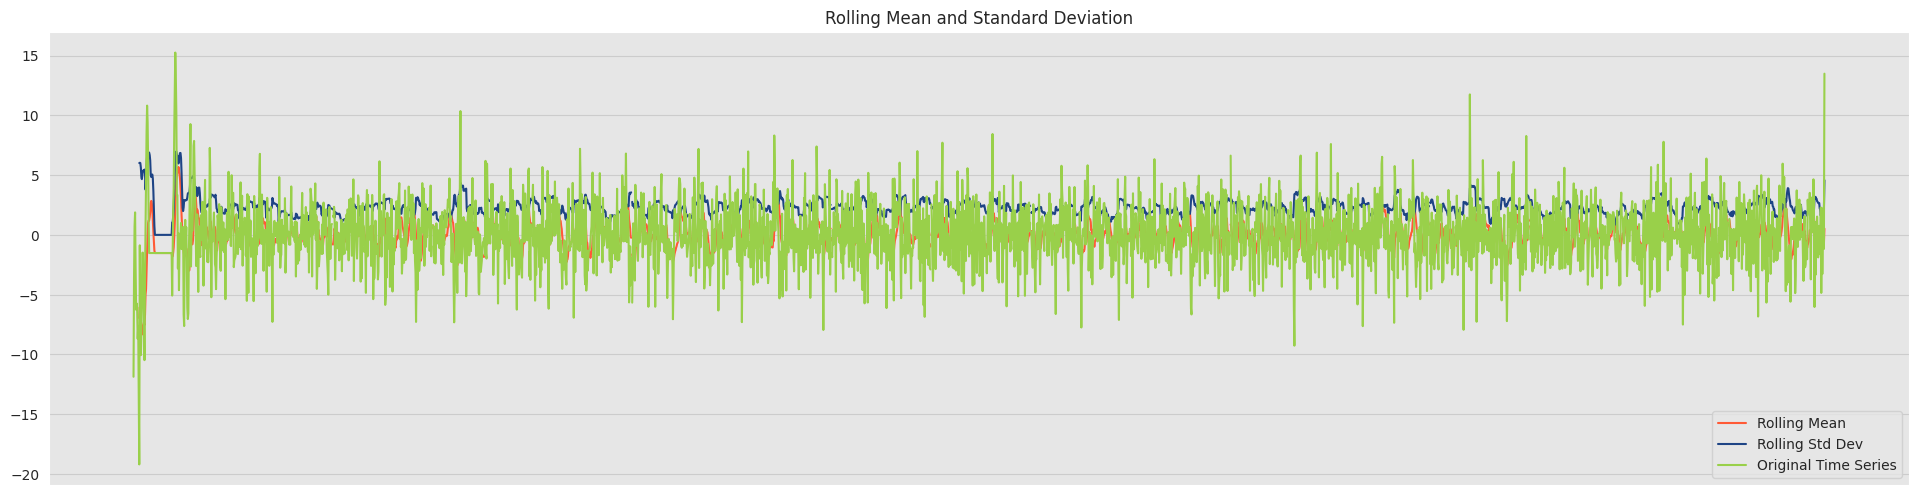

In [40]:
# De-trending the time series
df['Temperature_Detrend'] = (df['AverageTemperature'] - df['AverageTemperature'].shift(12))
stationarity_test(df, 'Temperature_Detrend', 'Zurich', significance_level=0.01)

In [27]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,day,dayofyear,Temperature_Detrend
date,,,,,,,,,,,,
1743-11-01,1743-11-01,6.068000,1.737,Århus,Denmark,57.05N,10.33E,1743,11,1,305,NaN
1743-12-01,1743-12-01,7.094947,NaN,Århus,Denmark,57.05N,10.33E,1743,12,1,335,NaN
1744-01-01,1744-01-01,6.634026,NaN,Århus,Denmark,57.05N,10.33E,1744,1,1,1,NaN
1744-02-01,1744-02-01,6.173105,NaN,Århus,Denmark,57.05N,10.33E,1744,2,1,32,NaN
1744-03-01,1744-03-01,5.741921,NaN,Århus,Denmark,57.05N,10.33E,1744,3,1,61,NaN


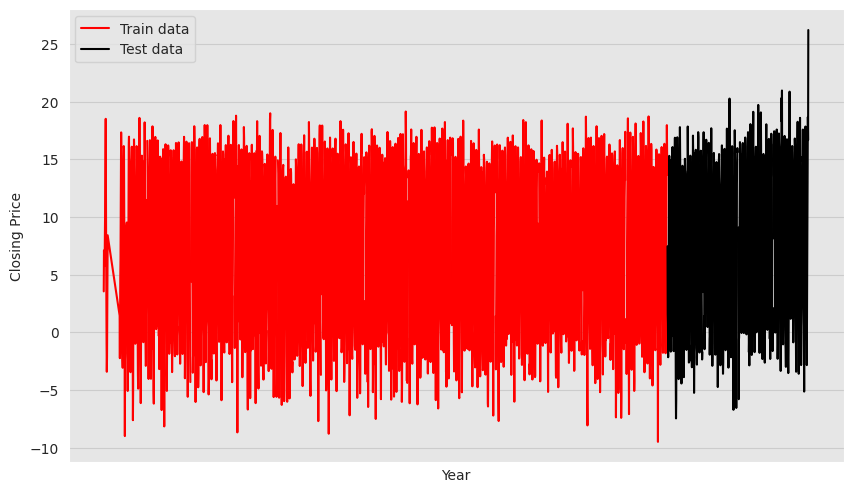

In [52]:
# Split data into train and test set
df_arima = df.query("City=='Zurich'")['AverageTemperature']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('AverageTemperature')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

/tmp/ipykernel_786/3793216688.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)
/tmp/ipykernel_786/3793216688.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)
/tmp/ipykernel_786/3793216688.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)
/tmp/ipykernel_786/3793216688.py:14: FutureWarning: The frame.append method is deprecated and will be removed from 

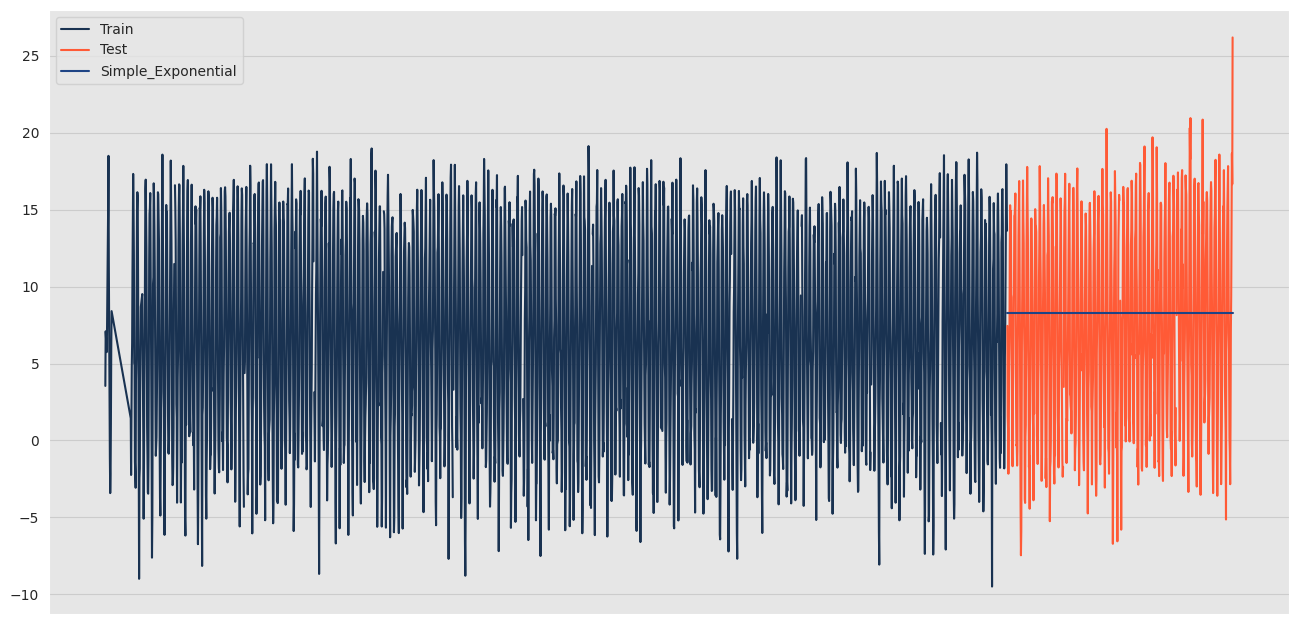

Simple Exponential Smoothing RMS :- 6.73 & Smoothing Level :- 0.05


In [53]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

/tmp/ipykernel_786/2784587160.py:6: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/tmp/ipykernel_786/2784587160.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)
/tmp/ipykernel_786/2784587160.py:6: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/tmp/ipykernel_786/2784587160.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0

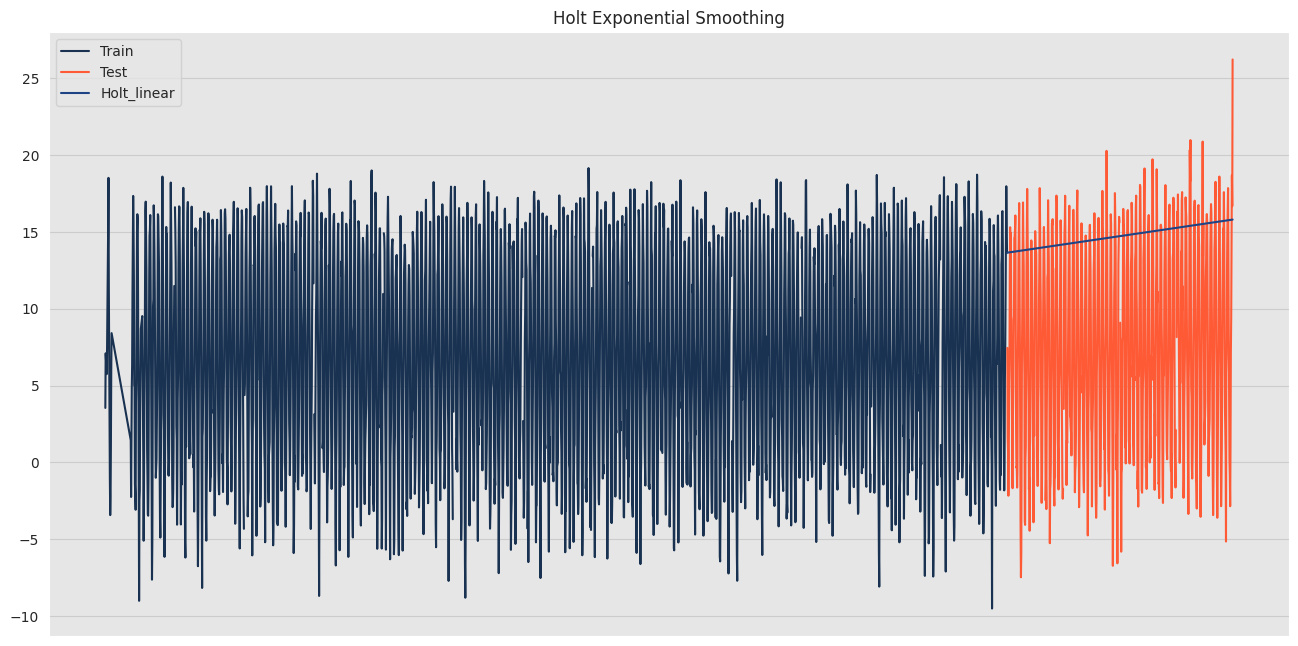

Holt’s Exponential Smoothing RMS :- 9.862 & Smoothing Level :- 1.0 & Smoothing Slope :- 0.35


In [54]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
    holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=13903.001, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18996.274, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14425.349, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16470.276, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=13331.744, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=13457.203, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=13218.777, Time=0.69 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=13224.470, Time=0.25 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=5.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=11434.297, Time=3.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13019.121, Time=0.50 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=11055.405, Time=6.02 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=10906.320, Time=6.07 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=6.15 sec
 ARIMA(5,0,3)(0,0,0)[0]        

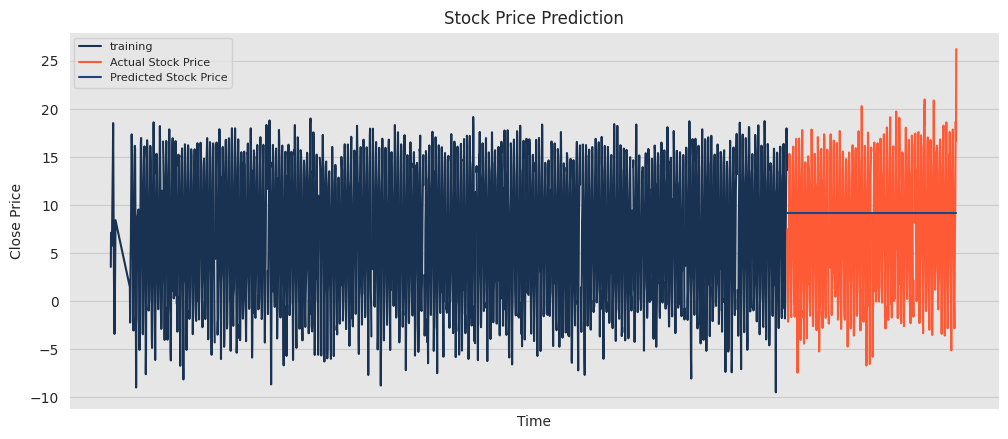

Auto-Arima RMSE :- 6.888


In [55]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False
                      )

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(fcv_series,label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

In [56]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

RMSE of all the methods
Auto-Arima:  6.888
Simple Exponential Smoothing:  6.73
Holt’s Exponential Smoothing:  9.862
